# Intrinisc alignments power spectra using the halo model
This example showcases how to use the halo model for intrinsic alignment within CCL to compute GI and II contributions to the shear-shear power spectrum.

In [25]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt

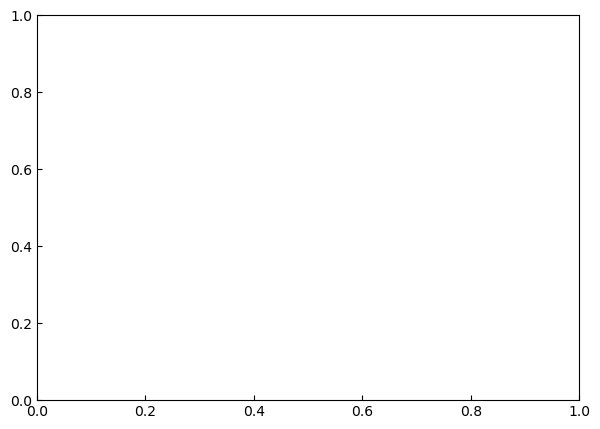

In [26]:
# Set default rcParams using plt.rc
plt.rc('figure', figsize=[7, 5])  # Default figure size
plt.rc('lines', linewidth=3, markersize=10)  # Default line width and marker size
plt.rc('image', cmap='cmr.pride')  # Default color map
plt.gca().tick_params(direction='in', which='both')  # Tick parameters for both xtick and ytick
plt.rc('axes', labelsize=15)  # Font sizes for x and y labels
plt.rc('legend', frameon=False, fontsize=12)  # Legend properties

# Default colors
def get_colors(data_len, cmap='cmr.pride'):
    return cmr.take_cmap_colors(cmap, data_len, cmap_range=(0.1, 0.9), return_fmt='hex')
# Use "plasma" colormap as well
plots_path = "plots_output/"

# Preliminaries
First we generate the cosmology, the wavenumber $k$ and scale factor $a$ arrays. The arrays are used for computing the power spectrum, $P(k,a)$.

In [27]:
#cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)
cosmo = ccl.CosmologyVanillaLCDM()

k_arr = np.geomspace(1E-3, 1e3, 128)  # For evaluating
lk_arr = np.log(k_arr)
a_arr = np.linspace(0.1, 1, 16)

We also need to initialize halo model quantities. These are:
 - A halo mass definition.
 - A concentration-mass relation.
 - A halo mass function.
 - A halo bias function.
 - A halo model calculator object that will take care of the various integrals.

In [28]:
# Here we use a mass definition with Delta = 200 times the matter density,
hm_def = '200m'
# the Duffy 2008 concentration-mass relation,
cM = ccl.halos.ConcentrationDuffy08(mass_def=hm_def)
# the Tinker 2010 halo mass function,
nM = ccl.halos.MassFuncTinker10(mass_def=hm_def)
# the Tinker 2010 halo bias,
bM = ccl.halos.HaloBiasTinker10(mass_def=hm_def)

# and the halo model calculator object.
hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=hm_def)

For this halo model, which is based on Fortuna et al. (2021, [https://arxiv.org/abs/2003.02700](https://arxiv.org/abs/2003.02700)), we will need a halo mass profile (taken to be an NFW) and a satellite intrinsic ellipticity/shear profile $\gamma^I(\mathbf{r}, M)$. Power spectra can then be computed by taking the Fourier transform of these profiles. To do this in CCL, we generate a satellite shear HOD:

In [29]:
sat_gamma_HOD = ccl.halos.SatelliteShearHOD(concentration=cM, mass_def=hm_def, a1h=0.001, b=-2)

# Satellite intrinsic shear profile
The real part of the satellite intrinsic shear profile is determined by $\bar{\gamma}$ which is taken to be
$$
\bar{\gamma}(r)= \begin{cases}a_{1 h}\left(\frac{0.06}{r_{\mathrm{vir}}}\right)^{b}, & \text { if } r<0.06 \mathrm{Mpc} / h \\ a_{1 h}\left(\frac{r}{r_{\mathrm{vir}}}\right)^{b}, & \text { if } r>0.06 \mathrm{Mpc} / h,\end{cases}
$$
while also imposing that $\bar{\gamma}(r)\leq0.3$. The parameters ```a1h``` and ```b``` are inputs to the satellite shear HOD above, together with a concentration-mass relation. For a constant mean intrinsic shear $\bar{\gamma}$, one can set ```b=0``` and the ```a1h``` parameter will determine $\bar{\gamma}$.

To obtain the Fourier transform of the profile, $\hat{\gamma}_s^I(\mathbf{k}, M)$, the FFTLog method will be used by default. Other methods are available but slower. The FFTLog parameters have been set internally to produce fast and accurate results, but can be further tweaked with the ```sat_gamma_HOD.update_precision_fftlog``` function. The real-space and Fourier-space intrinsic shear profiles at redshift 0 for a halo with $M_h=10^{14}$ M$_\odot$ look like this:

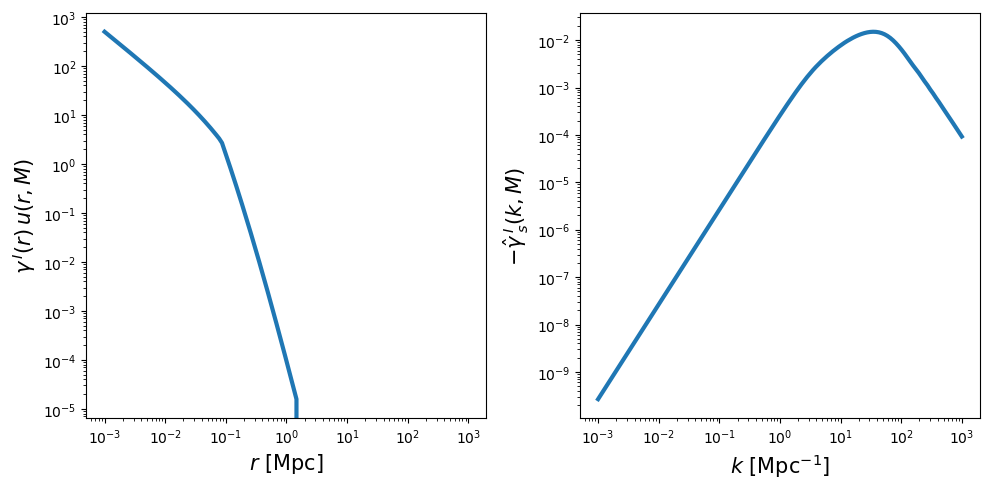

In [30]:
Mhalo = 1e14 # Msun.
a_eval = 1. # Redshift 0.

gamma_r = sat_gamma_HOD._real(cosmo, k_arr, Mhalo, a_eval)
gamma_k = sat_gamma_HOD._usat_fourier(cosmo, k_arr, Mhalo, a_eval)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(k_arr, gamma_r)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\gamma\,^I(r)\,u(r,M)\,$', fontsize=15)
ax[0].set_xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15)

ax[1].plot(k_arr, -gamma_k)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$-\hat{\gamma}\,_s^I(k, M)\,\,$', fontsize=15)
ax[1].set_xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
fig.tight_layout()
plt.show()

# Power spectra
The satellite intrinsic shear HOD profile easily allows for the computation of the 1-halo and 2-halo satellite contributions to the GI and II power spectra. The 2-halo central contribution is given by the linear alignment model and the 2-halo central-satellite II contribution is a little more involved. It is given by
$$
P_{\tilde{\gamma}\,^{\mathrm{I}},\, \mathrm{cs}}^{EE,\, 2 \mathrm{h}} (k) = C\, P_{\mathrm{lin}}(k )\int \mathrm{d}m \, n(m)\, \frac{\left\langle N^s_g\mid m \right\rangle}{\bar{n}_{g}} b_{\mathrm{h}}(m) \, \bar{\gamma}(m)
$$
where the integral can be computed with the ```pyccl.halos.halomod_bias_1pt``` function.

In [31]:
# Compute the II Power spectra
pk_II_1h_ss = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, get_2h = False, a_arr=a_arr, lk_arr=lk_arr)
pk_II_2h_ss = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, get_1h=False, a_arr=a_arr, lk_arr=lk_arr)

# Compute here the 2-halo c-s term:
A_IA = 1
C1rhocrit = 0.0134
C = A_IA * C1rhocrit * cosmo['Omega_m'] / cosmo.growth_factor(a_arr)
C_pk_lin = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                         pk_arr=C.reshape(-1,1)*cosmo.linear_matter_power(np.e**lk_arr, a_arr),
                         is_logp=False)
pk_b_gamma = -1 * ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                pk_arr=ccl.halos.halomod_bias_1pt(cosmo, hmc, np.e**lk_arr, a_arr,
                                                                  sat_gamma_HOD), is_logp=False)
pk_II_2h_cs = C_pk_lin * pk_b_gamma

pk_II_2h_cc = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                            pk_arr=C.reshape(-1,1)**2*cosmo.linear_matter_power(np.e**lk_arr, a_arr),
                            is_logp=False)
pk_II_total = pk_II_1h_ss + pk_II_2h_ss + pk_II_2h_cs + pk_II_2h_cc

In [32]:
# Compute below the GI power spectra
# NFW profile for matter (G)
NFW =  ccl.halos.HaloProfileNFW(mass_def=hm_def, concentration=cM, truncated=True, fourier_analytic=True)

pk_GI_1h_s = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW, prof2 = sat_gamma_HOD, get_2h = False, a_arr=a_arr, lk_arr=lk_arr)
pk_GI_2h_s = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW, prof2 = sat_gamma_HOD, get_1h = False, a_arr=a_arr, lk_arr=lk_arr)
pk_GI_2h_c = -1*C_pk_lin
pk_GI_total = pk_GI_1h_s + pk_GI_2h_s + pk_GI_2h_c

Let's also compute the NLA power spectra for comparison.

In [33]:
pk_II_NLA = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr, pk_arr=C.reshape(-1,1)**2*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr), is_logp=False)
pk_GI_NLA = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr, pk_arr=-C.reshape(-1,1)*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr), is_logp=False)

Here is what this all looks like:

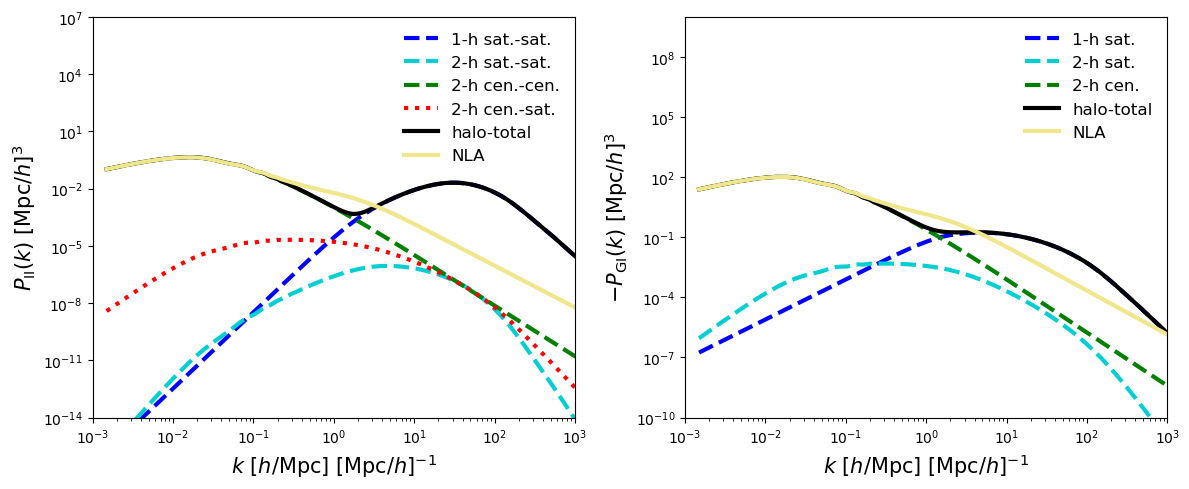

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
a_eval = 1/(1+0.11)
ax[0].loglog(k_arr/cosmo['h'], pk_II_1h_ss(k_arr, a_eval)*cosmo['h']**3, label='1-h sat.-sat.', c='blue', ls='--')
ax[0].loglog(k_arr/cosmo['h'], pk_II_2h_ss(k_arr, a_eval)*cosmo['h']**3, label='2-h sat.-sat.', c='darkturquoise', ls='--')
ax[0].loglog(k_arr/cosmo['h'], pk_II_2h_cc(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.-cen.', c='g', ls='--')
ax[0].loglog(k_arr/cosmo['h'], pk_II_2h_cs(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.-sat.', c='r', ls=':')
ax[0].loglog(k_arr/cosmo['h'], pk_II_total(k_arr, a_eval)*cosmo['h']**3, label='halo-total', c='k')
ax[0].loglog(k_arr/cosmo['h'], pk_II_NLA(k_arr, a_eval)*cosmo['h']**3, label='NLA', c='khaki')
ax[0].set_ylabel(r'$P_{\mathrm{II}}(k)$ [Mpc$/h$]$^3$', fontsize=15)
ax[0].set_xlabel(r'$k\,\,[h/{\rm Mpc}]$ [Mpc$/h$]$^{-1}$', fontsize=15)
ax[0].legend()
ax[0].set_xlim([1e-3, 1e3])
ax[0].set_ylim([1e-14, 1e7])

ax[1].loglog(k_arr/cosmo['h'], -pk_GI_1h_s(k_arr, a_eval)*cosmo['h']**3, label='1-h sat.', c='blue', ls='--')
ax[1].loglog(k_arr/cosmo['h'], -pk_GI_2h_s(k_arr, a_eval)*cosmo['h']**3, label='2-h sat.', c='darkturquoise', ls='--')
ax[1].loglog(k_arr/cosmo['h'], -pk_GI_2h_c(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.', c='g', ls='--')
ax[1].loglog(k_arr/cosmo['h'], -pk_GI_total(k_arr, a_eval)*cosmo['h']**3, label='halo-total', c='k')
ax[1].loglog(k_arr/cosmo['h'], -pk_GI_NLA(k_arr, a_eval)*cosmo['h']**3, label='NLA', c='khaki')
ax[1].set_ylabel(r'$-P_{\mathrm{GI}}(k)$ [Mpc$/h$]$^3$')
ax[1].set_xlabel(r'$k\,\,[h/{\rm Mpc}]$ [Mpc$/h$]$^{-1}$')
ax[1].legend()
ax[1].set_xlim([1e-3, 1e3])
ax[1].set_ylim([1e-10, 1e10])

fig.tight_layout()
plt.show()

### Galaxy position - shape power spectra
Using the HOD capabilities of CCL, we can also compute the correlation between galaxy positions and shapes with the halo model. This is done below.

In [35]:
# We first need a galaxy HOD
galaxyHOD = ccl.halos.HaloProfileHOD(concentration=cM, mass_def=hm_def)

# First we will try computing the cross-correaltion of the sattelite shear HOD and the galaxy HOD
pk_gI_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, prof2=galaxyHOD, get_2h = False, a_arr=a_arr, lk_arr=lk_arr)
pk_gI_2h_cs = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, prof2=galaxyHOD, get_1h = False, a_arr=a_arr, lk_arr=lk_arr)
b_g = 1. # Setting galaxy bias to 1 for illustration.
pk_gI_2h_cc = -1 * b_g * C_pk_lin

pk_gI_total = pk_gI_1h + pk_gI_2h_cs + pk_gI_2h_cc

# The NLA prediction:
pk_gI_NLA = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr, pk_arr=-C.reshape(-1,1)*b_g*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr), is_logp=False)

And here is what that looks like:

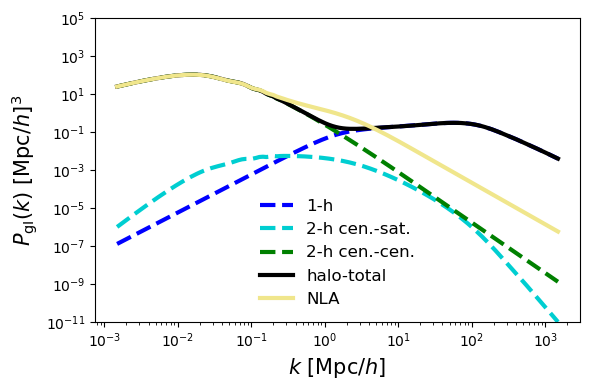

In [36]:
fig, ax = plt.subplots(1, figsize=(6,4))

ax.plot(k_arr/cosmo['h'], -pk_gI_1h(k_arr, a_eval)*cosmo['h']**3, label='1-h', c='blue', ls='--')
ax.plot(k_arr/cosmo['h'], -pk_gI_2h_cs(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.-sat.', c='darkturquoise', ls='--')
ax.plot(k_arr/cosmo['h'], -pk_gI_2h_cc(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.-cen.', c='green', ls='--')
ax.plot(k_arr/cosmo['h'], -pk_gI_total(k_arr, a_eval)*cosmo['h']**3, label='halo-total', c='black', ls='-')
ax.plot(k_arr/cosmo['h'], -pk_gI_NLA(k_arr, a_eval)*cosmo['h']**3, label='NLA', c='khaki', ls='-')
ax.set_ylabel(r'$P_{\mathrm{gI}}(k)$ [Mpc$/h$]$^3$', fontsize=15)
ax.set_xlabel(r'$k$ [Mpc$/h$]', fontsize=15)
ax.legend()

#a.set_xlim([1e-3, 1e3])
ax.set_ylim([1e-11, 1e5])
ax.set_xscale('log')
ax.set_yscale('log')

fig.tight_layout()
plt.show()

In [37]:
def prepare_data(k_arr, a_eval, cosmo_h, pk_functions, neg=False):
    data = {}
    for name, pk_func in pk_functions.items():
        y_values = pk_func(k_arr, a_eval) * cosmo_h**3
        if neg:
            y_values = -y_values
        data[name] = {'x': k_arr / cosmo_h, 'y': y_values}
    return data

# Define your pk_functions for each subplot
pk_functions_II = {
    '1-halo sat-sat': pk_II_1h_ss,
    '2-halo sat-sat': pk_II_2h_ss,
    '2-halo cen-cen': pk_II_2h_cc,
    '2-halo cen-sat': pk_II_2h_cs,
    'halo-total': pk_II_total,
    'NLA': pk_II_NLA,
}

pk_functions_GI = {
    '1-halo sat': pk_GI_1h_s,
    '2-halo sat': pk_GI_2h_s,
    '2-halo cen': pk_GI_2h_c,
    'halo-total': pk_GI_total,
    'NLA': pk_GI_NLA,
}

pk_function_gI = {
    '1-halo': pk_gI_1h,
    '2-halo cen-sat': pk_gI_2h_cs,
    '2-halo cen-cen': pk_gI_2h_cc,
    'halo-total': pk_gI_total,
    'NLA': pk_gI_NLA,
}

# Now combine the data into a single dictionary
data_dict = {
    'II': pk_functions_II,
    'GI': pk_functions_GI,
    'gI': pk_function_gI,
}

# Now use the function to prepare data for both subplots
halo_ia_data = {
    'II': prepare_data(k_arr, a_eval, cosmo['h'], pk_functions_II, neg=False),
    'GI': prepare_data(k_arr, a_eval, cosmo['h'], pk_functions_GI, neg=True),
    'gI': prepare_data(k_arr, a_eval, cosmo['h'], pk_function_gI, neg=True),
}

# Now save the data to npy file 
np.save('data/halo_model_ia_data.npy', halo_ia_data)

halo_ia_data.keys()


dict_keys(['II', 'GI', 'gI'])

On small scales the satellite 1-halo term dominates while on large scales alignments follow the NLA model.

Now we can compute the angular power spectrum of the total GI and II contributions using a redshift distribution and the CCL tracers. As an example, we show a redshift distribution at low redshift, where the alignment signal is strong.

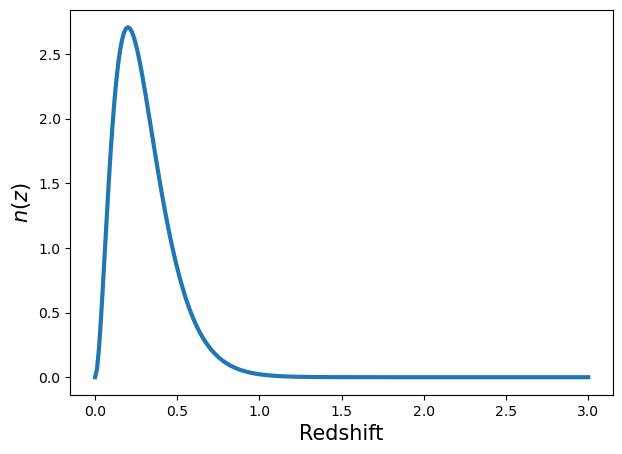

In [38]:
z_arr = np.linspace(0., 3., 256)
z0 = 0.1
pz = 1./(2.*z0) * (z_arr / z0)**2. * np.exp(-z_arr/z0)

plt.plot(z_arr, pz)
plt.xlabel('Redshift')
plt.ylabel('$n(z)$')

b_IA = np.ones(len(z_arr)) # A_IA = 1 in the NLA model
# A tracer without shear and A_ia contribution. The alignment signal is embedded in the power spectrum.
ia_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz), has_shear=False, ia_bias = (z_arr, b_IA), use_A_ia=False)
# A tracer without shear but with A_ia, to plot the NLA-only contribution for comparison.
ia_NLA_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz), has_shear=False, ia_bias = (z_arr, b_IA), use_A_ia=True)
# A weak gravitational lensing tracer for the GG and GI terms.
wl_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz))

l_arr = np.unique(np.geomspace(2, 60000, 256).astype(int))

cl_GI = ccl.angular_cl(cosmo, wl_tracer, ia_tracer, l_arr, p_of_k_a = pk_GI_total)
cl_II = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr, p_of_k_a = pk_II_total)
cl_GI_NLA = ccl.angular_cl(cosmo, wl_tracer, ia_NLA_tracer, l_arr)
cl_II_NLA = ccl.angular_cl(cosmo, ia_NLA_tracer, ia_NLA_tracer, l_arr)
cl_GG = ccl.angular_cl(cosmo, wl_tracer, wl_tracer, l_arr)

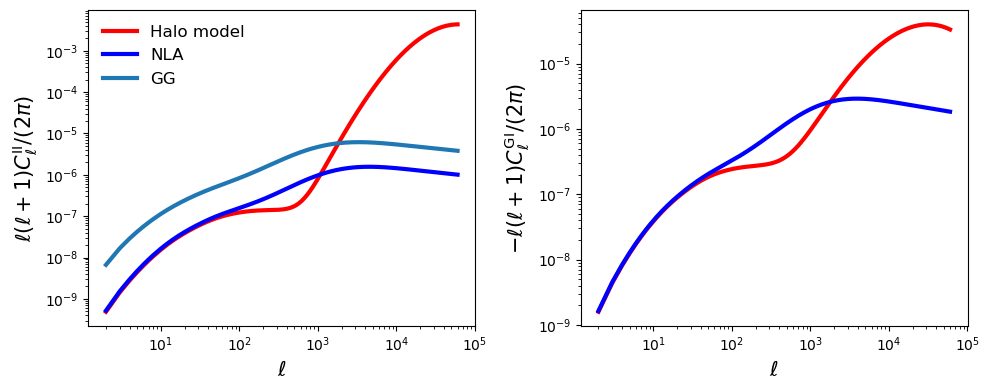

In [39]:
lfac = l_arr * (l_arr + 1) / (2 * np.pi)

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(l_arr, lfac * cl_II, label='Halo model', c='red')
ax[0].plot(l_arr, lfac * cl_II_NLA, label='NLA', c='blue')
ax[0].plot(l_arr, lfac * cl_GG, label='GG')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{\mathrm{II}}/(2\pi)$', fontsize=15)
ax[0].legend()

ax[1].plot(l_arr, -lfac * cl_GI, c='red')
ax[1].plot(l_arr, -lfac * cl_GI_NLA, c='blue')
ax[1].set_ylabel(r'$-\ell(\ell+1)C_\ell^{\mathrm{GI}}/(2\pi)$', fontsize=15)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_xlabel(r'$\ell$', fontsize=15)

fig.tight_layout()
plt.show()

# Windowed power spectra
We also show here how to generate an angular power spectrum that is determined by two window functions to treat double counting at intermediate scales, following what is done in Fortuna et al. 2021,
$$
P(k,a) = P_\mathrm{NLA}(k,a)\exp\left[-(k/k_\mathrm{2h})^2\right]+P_\mathrm{1h}^s(k,a)\left(1-\exp\left[-(k/k_\mathrm{1h})^2\right]\right)
$$
To incorporate this windowing, we need to generate arrays with values of $k$, $a$ and the relevant $P(k,a)$ and use them to create a new Pk2D object with these arrays.

In [16]:
k1h = 4*cosmo['h'] #1/Mpc
k2h = 6*cosmo['h'] #1/Mpc

pk_II_NLA_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                   pk_arr=C.reshape(-1,1)**2*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr)*np.exp(-(k_arr/k2h)**2).reshape(1,-1),
                                   is_logp=False)
pk_GI_NLA_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                   pk_arr=-C.reshape(-1,1)*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr)*np.exp(-(k_arr/k2h)**2).reshape(1,-1),
                                   is_logp=False)

pk_II_1h_ss_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                     pk_arr=pk_II_1h_ss(k_arr, a_arr)*(1-np.exp(-(k_arr/k1h)**2)).reshape(1,-1),
                                     is_logp=False)
pk_GI_1h_s_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                     pk_arr=pk_GI_1h_s(k_arr, a_arr)*(1-np.exp(-(k_arr/k1h)**2)).reshape(1,-1),
                                     is_logp=False)
pk_II_windowed = pk_II_NLA_windowed+pk_II_1h_ss_windowed
pk_GI_windowed = pk_GI_NLA_windowed+pk_GI_1h_s_windowed

Now, use the Pk2D objects to calculate the angular correlation functions.

In [17]:
cl_GI_windowed = ccl.angular_cl(cosmo, wl_tracer, ia_tracer, l_arr, p_of_k_a = pk_GI_windowed)
cl_II_windowed = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr, p_of_k_a = pk_II_windowed)

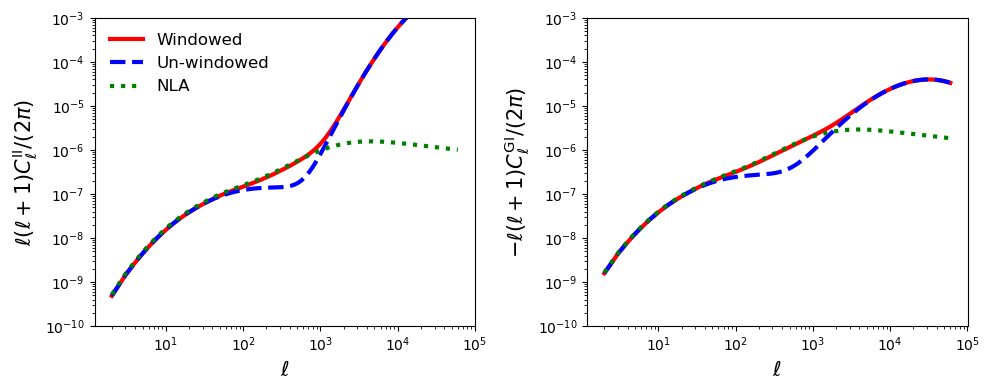

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(l_arr, lfac * cl_II_windowed, label='Windowed', c='red')
ax[0].plot(l_arr, lfac * cl_II, label='Un-windowed', c='blue', ls='--')
ax[0].plot(l_arr, lfac * cl_II_NLA, label='NLA', c='green', ls='dotted')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{\mathrm{II}}/(2\pi)$', fontsize=15)
ax[0].legend()

ax[1].plot(l_arr, -lfac * cl_GI_windowed, c='red')
ax[1].plot(l_arr, -lfac * cl_GI, label='Un-windowed', c='blue', ls='--')
ax[1].plot(l_arr, -lfac * cl_GI_NLA, label='NLA', c='green', ls='dotted')
ax[1].set_ylabel(r'$-\ell(\ell+1)C_\ell^{\mathrm{GI}}/(2\pi)$', fontsize=15)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_ylim([1e-10, 1e-3])
    a.set_xlabel(r'$\ell$', fontsize=15)

fig.tight_layout()
plt.show()

# Correlation functions

Below we also have a look at the $\xi_+$ correlation function with the different angular power spectra we have computed.

In [19]:
thetas = np.geomspace(1, 250, 40)
xip = ccl.correlation(cosmo, ell=l_arr, C_ell=cl_GG+cl_GI+cl_II, theta=thetas/60, type='GG+')
xip_NLA = ccl.correlation(cosmo, ell=l_arr, C_ell=cl_GG+cl_GI_NLA+cl_II_NLA, theta=thetas/60, type='GG+')
xip_windowed = ccl.correlation(cosmo, ell=l_arr, C_ell=cl_GG+cl_GI_windowed+cl_II_windowed, theta=thetas/60, type='GG+')

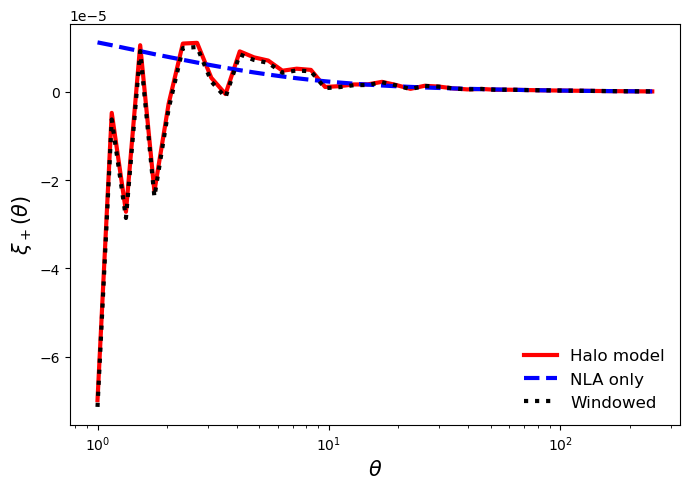

In [20]:
fig, ax = plt.subplots()

ax.plot(thetas, xip, label='Halo model', c='red')
ax.plot(thetas, xip_NLA, label='NLA only', c='blue', ls='--')
ax.plot(thetas, xip_windowed, label='Windowed', c='black', ls='dotted')
ax.set_ylabel(r'$\xi_+(\theta)$', fontsize=15)
ax.legend()

ax.set_xscale('log')
ax.set_xlabel(r'$\theta$', fontsize=15)

fig.tight_layout()
plt.show()

The difficulty in computing the correlation function likely has to do with the way FFTLog is set up in CCL at the moment, for this package. There is little flexibility in tweaking FFTLog's parameters in this case, and the new angular power spectra with the halo model are different enough that the FFTLog is not able to compute accurate correlation functions.

A workaround that one can implement is to compute the correlation function with a different python package, called ```wigner```, in the following way:

In [21]:
from wigner import wigner_dl
from scipy.interpolate import interp1d

def wigD_correlation(cosmo, l_arr,
                     tracer1, tracer2,
                     corr, theta,
                     p_of_k_a=None,
                     pm=1,
                     sampling=1e5,
                     show_prog=True):

    # set spin values based on correlation type provided
    if corr == 'NG':
        sa = 0
        sb = 2
    elif corr == 'GG':
        sa = 2
        sb = 2
    elif corr == 'NN':
        sa = 0
        sb = 0
    else:
        raise ValueError('Not a valid correlation type')
    # define a larger ell array for wigner matrix
    lmin = l_arr.min()
    lmax = int(lmin + sampling)
    ell_arr_sample = np.unique(np.geomspace(lmin, lmax, 1024).astype(int))
    # recompute angular cl
    Cl_sample = ccl.angular_cl(cosmo, tracer1, tracer2, ell_arr_sample, p_of_k_a=p_of_k_a)
    # interpolate to get high density array
    ell_arr  = np.arange(lmin, lmax)
    Cl_intp = interp1d(ell_arr_sample, Cl_sample)

    # loop over theta values and calculate xi at each
    xi = np.zeros_like(theta)
    for th in range(len(theta)):
        # get wigner-d matrix for given theta
        d_ell = wigner_dl(lmin, lmax, sa, sb, np.radians(theta[th]))
        # compute xi value for given theta by summing over ell values
        xi_temp = 0
        prefactor = (2*ell_arr + 1)/(4*np.pi)
        C_ab_l = pm**(sb) * Cl_intp(ell_arr)
        xi_temp += np.sum(prefactor * C_ab_l * d_ell[:-1])
        # record result to array
        xi[th] = xi_temp

    return xi

In [22]:
xip_wig_GI = wigD_correlation(cosmo, l_arr, wl_tracer, ia_tracer, 'GG', thetas/60,
                              p_of_k_a=pk_GI_total, sampling=4e6)
xip_wig_II = wigD_correlation(cosmo, l_arr, wl_tracer, ia_tracer, 'GG', thetas/60,
                              p_of_k_a=pk_II_total, sampling=4e6)
xip_GG = ccl.correlation(cosmo, ell=l_arr, C_ell=cl_GG, theta=thetas/60, type='GG+')
xip_tot = xip_GG+xip_wig_II+xip_wig_GI

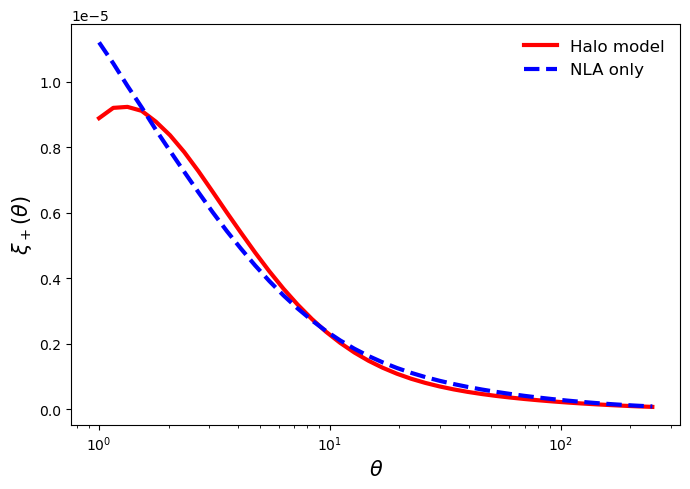

In [23]:
fig, ax = plt.subplots()

ax.plot(thetas, xip_tot, label='Halo model', c='red')
ax.plot(thetas, xip_NLA, label='NLA only', c='blue', ls='--')
ax.set_ylabel(r'$\xi_+(\theta)$', fontsize=15)
ax.legend()

ax.set_xscale('log')
ax.set_xlabel(r'$\theta$', fontsize=15)

fig.tight_layout()
plt.show()